<a href="https://colab.research.google.com/github/randaz99/DataScienceCommittee/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Top

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), cool 2D arrays
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
!pip install tensorflow_decision_forests #turn on or off if it's already downloaded
import tensorflow_decision_forests as tfdf
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# how to use google drive #
drive.mount('/content/drive')      #attaches itself to your google drive

# takes the training data spreadsheet (csv) and puts it into two panda arrays #
trainData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
testData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")

names = ["RandomForest200",
         "LinearSVC",
         "MultinomialNB",
         "Logistic",
         "KNN5",
         "SVCLinear",
         "SVCgamma2",
         "DecisionTree5",
         #"RandomForest5-10",
         #"MLP-2000-1000-500-100",
         "AdaBoost",
         "HistGradientBoost",
         "GradientBoosting",  # New model
         "Bagging"            # New model
        ]


abrevNames = ["RF2",
         "LSVC",
         "MNB",
         "Log",
         "KNN5",
         "SVCL",
         "SVCg",
         "DT5",
         #"RF51",
         #"MLP",
         "AB",
         "HGB",
         "GB",    # New model
         "Bag"    # New model
        ]

models = [
        RandomForestClassifier(n_estimators=1000, max_depth=7, random_state=0),
        LinearSVC(max_iter=750, dual=True),
        MultinomialNB(),
        LogisticRegression(random_state=5),
        KNeighborsClassifier(n_neighbors=6, weights="uniform"),
        SVC(kernel="linear", C=2.2),
        SVC(gamma=0.34, C=2),
        DecisionTreeClassifier(max_depth=15),
        #RandomForestClassifier(n_estimators=750, max_depth=7, max_features=3),
        #MLPClassifier(hidden_layer_sizes=(2000,1000,500,100)),
        #MLPClassifier(hidden_layer_sizes=(100,50,10)),
        AdaBoostClassifier(),
        HistGradientBoostingClassifier(categorical_features=[]),
        GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=.1),  # New model
        BaggingClassifier(n_estimators=300)            # New model
    ]

"""The funtions bellow act on the data"""
# just prints the data
def printData():
  pd.set_option("display.max_rows", 10)
  print(f"Train data=\n{trainData}")
  print(f"Test data=\n{testData}")

# makes the column Family column which is the sum of Sibsp (siblingings/spouses) and Parch (Parens/Children)
def family():
  trainData["Family"] = trainData["SibSp"] + trainData["Parch"]
  testData["Family"] = testData["SibSp"] + testData["Parch"]

  print("   Created 'Family' column.")


# makes the column Last Name column which is just the peroson last name
def lastName():
  trainData["LastName"] = trainData["Name"].str.split(',').str[0]
  testData["LastName"] = testData["Name"].str.split(',').str[0]

  print("   Created 'LastName' column.")

# This is a function
def makeFamCodes():
  trainNameSet = set(trainData["LastName"])
  testNameSet = set(testData["LastName"])

  print(f"THIS IS MY SET {trainNameSet}")

  trainData["FamCode"] = ''
  testData["FamCode"] = ''

  i = 0
  for name in trainNameSet:
    trainData["FamCode"] += trainData["LastName"].apply(lambda s: str(i) if s == name else "")

    i = i + 1

  i = 0
  for name in testNameSet:
    testData["FamCode"] += testData["LastName"].apply(lambda s: str(i) if s == name else "")

    i = i + 1


# FILLING in NULLS #
#Takes all the nulls and puts in the mean/average of the col
def wrangleQ0():
# Extract numerical part from "Cabin" column
  trainData['Cabin'] = trainData['Cabin'].str.extract('(\d+)')
  testData['Cabin'] = testData['Cabin'].str.extract('(\d+)')

# Convert numerical part to numeric type
  trainData['Cabin'] = pd.to_numeric(trainData['Cabin'], errors='coerce')
  testData['Cabin'] = pd.to_numeric(testData['Cabin'], errors='coerce')

# Replace missing values in "Cabin" with mean
  trainData['Cabin'].fillna(trainData['Cabin'].mean(), inplace=True)
  testData['Cabin'].fillna(testData['Cabin'].mean(), inplace=True)

# Extract numerical part from "Ticket" column
  trainData['Ticket'] = trainData['Ticket'].str.extract('(\d+)')
  testData['Ticket'] = testData['Ticket'].str.extract('(\d+)')

# Convert numerical part to numeric type
  trainData['Ticket'] = pd.to_numeric(trainData['Ticket'], errors='coerce')
  testData['Ticket'] = pd.to_numeric(testData['Ticket'], errors='coerce')

# Replace missing values in "Ticket" with mean
  trainData['Ticket'].fillna(trainData['Ticket'].mean(), inplace=True)
  testData['Ticket'].fillna(testData['Ticket'].mean(), inplace=True)

  trainData["Age"] = trainData["Age"].fillna(trainData["Age"].mean())
  testData["Age"] = testData["Age"].fillna(testData["Age"].mean())

  trainData["Fare"] = trainData["Fare"].fillna(trainData["Fare"].mean())
  testData["Fare"] = testData["Fare"].fillna(testData["Fare"].mean())

  print("   Nulls Filled.")


# Remove rows with nulls in them #
def wrangleDelNull():
  trainData.dropna(inplace=True)
  testData.dropna(inplace=True)


# forces all numeric data to be withing 0 to 1
#has optional param that acccepts a list of columns to ignore
def wrangleNorm(exclude=[]):
  # change this to do all numeric columns!
  tempDF = testData.select_dtypes(include=np.number)
  columns = []

  # this is for if you want to exclude a ceetain column (feature)
  # it only adds colmuns that are not in th einclude list tot he columns list
  for col in tempDF.columns:
    if (col not in exclude):
      columns = columns + [col]

  #iterates through every numeric column
  for col in columns:
      trainData[col] = (trainData[col] - trainData[col].min()) / (trainData[col].max() - trainData[col].min())
      testData[col] = (testData[col] - testData[col].min()) / (testData[col].max() - testData[col].min())

  print("   Normalized numeric columns.")



"""The functions below display information about the data"""
# This predicts importance of our features #
def predictImportance():
    tfDataSet = tfdf.keras.pd_dataframe_to_tf_dataset(trainData, label='Survived')

    model = tfdf.keras.RandomForestModel()
    model.fit(tfDataSet)

    print(model.summary())


# displays correlation data give a training data set #
def displayCorrelations():
                                          #Correlation values
    print(f"\nCorrelation Summary:\nPearson Coef:{trainData.corr(method = 'pearson')}\n\nKendall Coef:{trainData.corr(method = 'kendall')}\n\nSpearman Coef:{trainData.corr(method = 'spearman')}\n")

    #big corrolation chart
    trainData.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)
    plt.tight_layout(pad=2)
    plt.show()
    # histograms
    trainData.hist()
    plt.tight_layout(pad=2)
    plt.show()
    # scatter plot matrix
    scatter_matrix(trainData)
    plt.tight_layout(pad=.1)
    plt.show()


# This tests the models #
def testModels(features):
    print(f"\nTesting models based on: {features}")
    # what we want to predict #
    y = trainData["Survived"]

    # Change Categorical to numeric #
    X = pd.get_dummies(trainData[features])

    results = []

    i = 0
    for model in models:
        kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
        model_name = names[i]
        i = i + 1
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        print('%s: %f (%f)' % (model_name, cv_results.mean(), cv_results.std()))

    plt.boxplot(results, labels=abrevNames)
    plt.title('Algorithm Comparison')
    plt.show()


def outputPredictionsList(features):
    print(f"   Using Features: {features}")
    # what we want to predict #
    y = trainData["Survived"]

    # Change Categorical to numeric #
    X = pd.get_dummies(trainData[features])
    XTest = pd.get_dummies(testData[features])

    predictionsList = []

    for model in models:
        model.fit(X, y)
        prediction = model.predict(XTest)
        predictionsList.append(prediction)

    return np.array(predictionsList)

# Takes each models predictions for each person and takes the average to round to the most likely outcome
def outputConcensus(preditcionsList):
  print("   Making Concensus...")
  concensus = np.mean(predictionsList, axis=0)
  #print(concensus)
  return (np.rint(concensus)).astype(int)

# Create an output dataframe and write it to csv file #
def modelToCSV(prediction):
    output = pd.DataFrame({'PassengerId': testData.PassengerId, "Survived": prediction})
    output.to_csv('submission.csv', index=False)

    # just so we can see the submission in the console #
    submission = pd.read_csv('submission.csv')
    print(f"CSV submission conents:\n{submission}")

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Method Calls


Wrangling...
   Nulls Filled.
   Normalized numeric columns.

Creating Features...
   Created 'Family' column.
   Created 'LastName' column.
THIS IS MY SET {'Coleridge', 'Hale', 'Birkeland', 'Frauenthal', 'Augustsson', 'Burke', 'Partner', 'Lesurer', 'Madigan', 'Romaine', 'Hocking', 'Kassem', 'Cavendish', 'Faunthorpe', 'Mack', 'Maenpaa', 'Mitkoff', 'Molson', 'Peduzzi', 'Mellors', 'Touma', 'Clarke', 'Attalah', 'McNamee', 'Jansson', "O'Connell", 'Slayter', 'Doling', 'Karaic', 'de Pelsmaeker', 'Padro y Manent', 'Ross', 'Niskanen', 'del Carlo', "O'Connor", 'Healy', 'Madill', 'Eklund', 'Culumovic', 'Calderhead', 'Ohman', 'Yousseff', 'Heikkinen', 'Bostandyeff', 'Backstrom', 'Compton', 'Ward', 'Sadlier', 'Taylor', 'Chambers', 'Behr', 'Cairns', 'Thorne', 'Wiklund', 'Frolicher', 'Adahl', 'Douglas', 'Novel', 'Svensson', 'Kink-Heilmann', 'Skoog', 'Johnson', 'Hood', "O'Leary", 'Bishop', 'Radeff', 'Badt', 'Cleaver', 'Stewart', 'Zabour', 'Braund', 'Hoyt', 'McGough', 'Lindblom', 'Arnold-Franchi', 'Bu

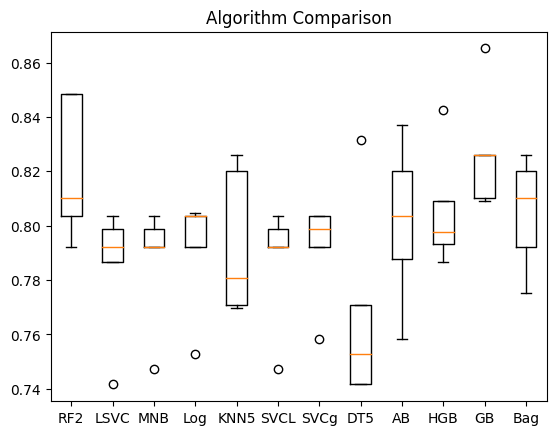


Predicting...
   Using Features: ['Sex', 'Fare', 'Age', 'Family', 'Pclass', 'Ticket', 'Cabin', 'Embarked', 'FamCode']


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- FamCode_1000
- FamCode_1001
- FamCode_1002
- FamCode_1003
- FamCode_1004
- ...
Feature names seen at fit time, yet now missing:
- FamCode_0
- FamCode_1
- FamCode_10
- FamCode_100
- FamCode_101
- ...


In [7]:
# METHOD CALLS #

#displayCorrelations(trainData)

""" WRANGLING """
print('\nWrangling...')
wrangleQ0()
#wrangleDelNull(trainData, testData)
wrangleNorm(exclude=["PassengerId"])
#printData()

""" FEATURE ENGINEERING """
print('\nCreating Features...')
family()
lastName()
makeFamCodes()
printData()

# feature sets! #
features = ["Sex","Fare","Age","SibSp","Parch"]
features1 = ["Sex","Fare","Age","SibSp","Parch","Ticket","Embarked"]
features2 = ["Sex","Fare","Age","Family","Pclass","Ticket","Cabin","Embarked","FamCode"]
featuresALL = ["Sex","Fare","Age","Family","Pclass","Name","Ticket","Cabin","Embarked","PassengerId","FamCode"]

""" TESTING """
#predictImportance()
testModels(features)
#testModels(features1)
#testModels(features2)
#testModels(featuresALL)

""" For  predictiing & submitting """
print('\nPredicting...')
#prediction = outPrediction()
predictionsList = outputPredictionsList(features2)
#print(predictionsList)
concensus = outputConcensus(predictionsList)
#print(concensus)
modelToCSV(concensus)